# Data preprocessing

In [1]:
#%pip install spacy

In [2]:
#%pip install spacy-langdetect

## 1) Data loading

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline


In [4]:
# Read CSV file with reviews into a DataFrame
path = '../data/Reviews.csv'
reviews = pd.read_csv(path)

In [5]:
reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
# Drop customer profile name as this is not useful and even if we need to identify customers we can do it through the unique UserId
reviews.drop("ProfileName", axis=1, inplace=True)

In [7]:
reviews.head()

,Id,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [8]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   HelpfulnessNumerator    568454 non-null  int64 
 4   HelpfulnessDenominator  568454 non-null  int64 
 5   Score                   568454 non-null  int64 
 6   Time                    568454 non-null  int64 
 7   Summary                 568427 non-null  object
 8   Text                    568454 non-null  object
dtypes: int64(5), object(4)
memory usage: 39.0+ MB


## 2) Preprocessing

### Type conversion

In [9]:
# Convert ProductId, UserId, Summary and Text to string format
reviews['ProductId'] = reviews['ProductId'].astype('str')
reviews['UserId'] = reviews['UserId'].astype('str')
reviews['Summary'] = reviews['Summary'].astype('str')
reviews['Text'] = reviews['Text'].astype('str')

### Renaming columns

In [10]:
# Renaming columns
reviews = reviews.rename(columns={'Id': 'id', 'ProductId': 'product_id', 'UserId': 'user_id', 'HelpfulnessNumerator': 'helpfulness_numerator',
                                  'HelpfulnessDenominator': 'helpfulness_denominator', 'Score': 'score', 'Time': 'time', 'Summary': 'summary',
                                  'Text': 'text'})

In [11]:
reviews.head()

,id,product_id,user_id,helpfulness_numerator,helpfulness_denominator,score,time,summary,text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Adding extra columns

* date from timestamp
* sentiment from score
* helpfulness ratio
* number of words in review

In [12]:
# Convert timestamp to date
reviews['date'] = pd.to_datetime(reviews['time'], unit='s')


In [13]:
reviews.head()

,id,product_id,user_id,helpfulness_numerator,helpfulness_denominator,score,time,summary,text,date
0,1,B001E4KFG0,A3SGXH7AUHU8GW,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27
1,2,B00813GRG4,A1D87F6ZCVE5NK,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07
2,3,B000LQOCH0,ABXLMWJIXXAIN,1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,2008-08-18
3,4,B000UA0QIQ,A395BORC6FGVXV,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,2011-06-13
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,2012-10-21


In [14]:
# Check min and max values of date column to check if datetime conversions are ok
print(min(reviews['date']))
print(max(reviews['date']))

1999-10-08 00:00:00
2012-10-26 00:00:00


Dates output seems consistent with the starting date referenced by the author of the dataset in https://snap.stanford.edu/data/web-FineFoods.html

In [15]:
reviews['year'] = reviews['date'].dt.year

In [16]:
def sentiment_from_score(score):
    if score < 3 and score >= 1:
        return 'negative'
    elif score == 3:
        return 'neutral'
    elif score > 3:
        return 'positive'
    else:
        return 'NA'

reviews['sentiment'] = reviews.apply(lambda row: sentiment_from_score(row['score']), axis=1)

In [17]:
reviews['helpfulness_ratio'] = reviews['helpfulness_numerator'] / reviews['helpfulness_denominator']

In [18]:
def word_count(text):

    return len(text.split())

In [19]:
reviews['word_count'] = reviews.apply(lambda row: word_count(row['text']), axis=1)

### Check for empty reviews

In [20]:
reviews[reviews['text']==""].shape[0]

0

There don't seem to be any records with empty text reviews.

### Analysis for duplicates

In [21]:
initial_num_records = reviews['text'].shape[0]

In [22]:
reviews['text'].duplicated()

0         False
1         False
2         False
3         False
4         False
          ...  
568449    False
568450    False
568451    False
568452    False
568453    False
Name: text, Length: 568454, dtype: bool

In [23]:
reviews['duplicated'] = reviews['text'].duplicated()

In [24]:
# Check if there are any duplicates in the review text
print(f"# of duplicated records in the review text: {sum(reviews['text'].duplicated())} ({sum(reviews['text'].duplicated())/initial_num_records*100:.2f}% of all)")

# Get reviews that have the same text and product_id
print(f"# of reviews with the same product_id and text: {sum(reviews.duplicated(subset=['product_id','text']))} ({sum(reviews.duplicated(subset=['product_id','text']))/initial_num_records*100:.2f}% of all)")


# Get reviews that have the same text, user_id and product_id
print(f"# of reviews with the same user_id, product_id and text: {sum(reviews.duplicated(subset=['user_id','product_id','text']))} ({sum(reviews.duplicated(subset=['user_id','product_id','text']))/initial_num_records*100:.2f}% of all)")


# of duplicated records in the review text: 174875 (30.76% of all)
# of reviews with the same product_id and text: 1324 (0.23% of all)
# of reviews with the same user_id, product_id and text: 1309 (0.23% of all)


Not only are there duplicated reviews for the same product but from different users, but also duplicated reviews that concern the same user and product. We should at least remove the ones that have the same user_id, product_id and text. One way to do it would be to keep either the first or the latest review among these duplicates.

It may make more sense to just remove reviews that have the same user_id, product_id and text since it could happen that some duplicate reviews are short sentences that more than one person can write or a user may agree with another and copy their review. In the latter case, this review accurately reflects the user's opinion and he simply didn't bother to write an original text review.

In [25]:
# Drop record duplicates with the same user_id, product_id and review text keeping only the earliest or latest review

def drop_same_user_product_text(df, keep='first'):
    
    drop_mask = df.sort_values(by='date', ascending=True).duplicated(subset=['user_id','product_id','text'], keep=keep)

    df = df[~drop_mask]

    return df

In [26]:
# Drop record duplicates with the same review text for the same product_id keeping only the earliest or latest review

def drop_same_product_text(df, keep='first'):

    drop_mask = df.sort_values(by='date', ascending=True).duplicated(subset=['product_id','text'], keep=keep)

    df = df[~drop_mask]

    return df

In [27]:
# Drop record duplicates with the same list of columns, keeping only the earliest or latest review

def drop_same_cols(df, col_list, keep='first'):
    
    drop_mask = df.sort_values(by='time', ascending=True).duplicated(subset=col_list, keep=keep)

    df = df[~drop_mask]

    return df

In [28]:
reviews.shape[0]

568454

In [29]:
reviews = drop_same_user_product_text(reviews, keep='first')


C:\Users\j.martins\AppData\Local\Temp\ipykernel_29488\2736135404.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[~drop_mask]


In [30]:
reviews.shape[0]

567145

In [31]:
reviews.head()

,id,product_id,user_id,helpfulness_numerator,helpfulness_denominator,score,time,summary,text,date,year,sentiment,helpfulness_ratio,word_count,duplicated
0,1,B001E4KFG0,A3SGXH7AUHU8GW,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27,2011,positive,1.0,48,False
1,2,B00813GRG4,A1D87F6ZCVE5NK,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07,2012,negative,NaN,31,False
2,3,B000LQOCH0,ABXLMWJIXXAIN,1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,2008-08-18,2008,positive,1.0,94,False
3,4,B000UA0QIQ,A395BORC6FGVXV,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,2011-06-13,2011,negative,1.0,41,False
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,2012-10-21,2012,positive,NaN,27,False


In [32]:
print(f"# remaining reviews after dropping duplicates = {reviews.shape[0]}")

# remaining reviews after dropping duplicates = 567145


#### Analysis of dispersion of duplicated reviews relative to the first published one for a product_id in terms of time and score

* for each product_id in the duplicated reviews, get the earliest review of that item
* calculate absolute difference of score and number of days between duplicated reviews and the earliest
* plot distribution of these differences

In [33]:
duplicated_reviews = reviews[reviews['duplicated']]

In [34]:
duplicated_reviews.index

Int64Index([    29,    603,   1973,   2309,   2323,   2336,   2653,   2947,
              3885,   3886,
            ...
            568401, 568402, 568403, 568407, 568408, 568409, 568410, 568411,
            568412, 568413],
           dtype='int64', length=173672)

In [35]:
duplicated_reviews.shape[0]

173672

In [36]:
duplicated_reviews['time']

29        1107820800
603       1229385600
1973      1312675200
2309      1127606400
2323      1127606400
             ...    
568409    1309651200
568410    1332979200
568411    1319500800
568412    1336435200
568413    1330041600
Name: time, Length: 173672, dtype: int64

In [37]:
# Add column with earliest time for group of reviews
earliest_time = duplicated_reviews.groupby(['product_id','text']).time.transform(lambda x: x.min())

earliest_time.rename('earliest_time', inplace=True)

29        1107820800
603       1229385600
1973      1312675200
2309      1127606400
2323      1127606400
             ...    
568409    1309651200
568410    1332979200
568411    1319500800
568412    1336435200
568413    1330041600
Name: earliest_time, Length: 173672, dtype: int64

In [38]:
# Add column with score of earliest review
earliest_score = duplicated_reviews.sort_values('time').groupby(['product_id','text'])['score'].transform('first')

earliest_score.rename('earliest_score', inplace=True)

374358    5
451877    5
374421    5
451948    5
374342    1
         ..
237868    4
478116    5
195977    5
466640    5
304158    5
Name: earliest_score, Length: 173672, dtype: int64

In [39]:
# Add column with helpfulness ratio of earliest review
earliest_helpr = duplicated_reviews.sort_values('time').groupby(['product_id','text'])['helpfulness_ratio'].transform('first')

earliest_helpr.rename('earliest_helpr', inplace=True)

374358    0.500000
451877    0.500000
374421    1.000000
451948    1.000000
374342    0.826087
            ...   
237868         NaN
478116         NaN
195977         NaN
466640         NaN
304158         NaN
Name: earliest_helpr, Length: 173672, dtype: float64

In [40]:
earliest_time.shape[0]

173672

In [41]:
earliest_score.shape[0]

173672

In [42]:
duplicated_reviews = duplicated_reviews.merge(earliest_time.to_frame(), left_index=True, right_index=True)

duplicated_reviews = duplicated_reviews.merge(earliest_score.to_frame(), left_index=True, right_index=True)

duplicated_reviews = duplicated_reviews.merge(earliest_helpr.to_frame(), left_index=True, right_index=True)

In [43]:
duplicated_reviews.shape[0]

173672

In [44]:
duplicated_reviews.head()

,id,product_id,user_id,helpfulness_numerator,helpfulness_denominator,score,time,summary,text,date,year,sentiment,helpfulness_ratio,word_count,duplicated,earliest_time,earliest_score,earliest_helpr
29,30,B0001PB9FY,A3HDKO7OW0QNK4,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...,2005-02-08,2005,positive,1.0,146,True,1107820800,5,1.0
603,604,B000G6RYNE,A3PJZ8TU8FDQ1K,1,1,5,1229385600,"One bite and you'll become a ""chippoisseur""","I'm addicted to salty and tangy flavors, so wh...",2008-12-16,2008,positive,1.0,242,True,1229385600,5,1.0
1973,1974,B0017165OG,A2EPNS38TTLZYN,0,0,3,1312675200,Pok Chops,The pork chops from Omaha Steaks were very tas...,2011-08-07,2011,neutral,NaN,39,True,1312675200,3,NaN
2309,2310,B0001VWE0M,AQM74O8Z4FMS0,0,0,2,1127606400,Below standard,Too much of the white pith on this orange peel...,2005-09-25,2005,negative,NaN,25,True,1127606400,2,NaN
2323,2324,B0001VWE0C,AQM74O8Z4FMS0,0,0,2,1127606400,Below standard,Too much of the white pith on this orange peel...,2005-09-25,2005,negative,NaN,25,True,1127606400,2,NaN


In [45]:
duplicated_reviews['diff_secs'] = abs(duplicated_reviews['time']-duplicated_reviews['earliest_time'])

In [46]:
duplicated_reviews['diff_secs'].value_counts()

0           173671
11491200         1
Name: diff_secs, dtype: int64

In [47]:
duplicated_reviews['diff_score'] = abs(duplicated_reviews['score']-duplicated_reviews['earliest_score'])

In [48]:
duplicated_reviews['diff_score'].value_counts()

0    173672
Name: diff_score, dtype: int64

In [49]:
duplicated_reviews['diff_helpr'] = abs(duplicated_reviews['helpfulness_ratio']-duplicated_reviews['earliest_helpr'])

In [50]:
duplicated_reviews['diff_helpr'].value_counts()

0.00    88577
0.05        1
0.50        1
Name: diff_helpr, dtype: int64

Out of the 173672 duplicated reviews, all but one have the same timestamp and score, which means that they must belong to the same user, as another user would not be able to copy the review and post it in the same second as the earliest review was posted.

For these records it suffices to keep the first one as the others must be a mistake in the data.

In [51]:
# Checking duplicate review that has the large time difference
duplicated_reviews[duplicated_reviews['diff_secs']==11491200]

,id,product_id,user_id,helpfulness_numerator,helpfulness_denominator,score,time,summary,text,date,...,sentiment,helpfulness_ratio,word_count,duplicated,earliest_time,earliest_score,earliest_helpr,diff_secs,diff_score,diff_helpr
565139,565140,B001EO5U3I,A1MHI2RJAE5BBJ,1,1,5,1238284800,The Best Oatmeal,I bought a 4-pack of this oatmeal for a reason...,2009-03-29,...,positive,1.0,36,True,1226793600,5,0.5,11491200,0,0.5


In [52]:
# Checking duplicate reviews that have nonzero helpfulness ratio
duplicated_reviews[duplicated_reviews['diff_helpr'] > 0]

,id,product_id,user_id,helpfulness_numerator,helpfulness_denominator,score,time,summary,text,date,...,sentiment,helpfulness_ratio,word_count,duplicated,earliest_time,earliest_score,earliest_helpr,diff_secs,diff_score,diff_helpr
367217,367218,B001E6KBJ4,A31I7JTKSVW5ER,7,10,1,1347062400,Disappointed with Kelloggs,I no longer will buy anything Kelloggs makes b...,2012-09-08,...,negative,0.7,69,True,1347062400,1,0.75,0,0,0.05
565139,565140,B001EO5U3I,A1MHI2RJAE5BBJ,1,1,5,1238284800,The Best Oatmeal,I bought a 4-pack of this oatmeal for a reason...,2009-03-29,...,positive,1.0,36,True,1226793600,5,0.50,11491200,0,0.50


In [53]:
special_case_product_id = duplicated_reviews[duplicated_reviews['diff_secs']==11491200]['product_id'].loc[565139]
special_case_text = duplicated_reviews[duplicated_reviews['diff_secs']==11491200]['text'].loc[565139]

print(f"special duplicate case product_id = {special_case_product_id}")
print(f"special duplicate case text = {special_case_text}")

special duplicate case product_id = B001EO5U3I
special duplicate case text = I bought a 4-pack of this oatmeal for a reason; it's worth it. The flavor is so rich and nutty. The texture is perfect. If you like oatmeal, buy this - it's also a great value!


In [54]:
reviews[(reviews['product_id'] == special_case_product_id) & (reviews['text'] == special_case_text)]

,id,product_id,user_id,helpfulness_numerator,helpfulness_denominator,score,time,summary,text,date,year,sentiment,helpfulness_ratio,word_count,duplicated
565139,565140,B001EO5U3I,A1MHI2RJAE5BBJ,1,1,5,1238284800,The Best Oatmeal,I bought a 4-pack of this oatmeal for a reason...,2009-03-29,2009,positive,1.0,36,True
565333,565334,B001EO5U3I,A1Z46QE3HMBB2B,1,2,5,1226793600,Best Oatmeal in the World,I bought a 4-pack of this oatmeal for a reason...,2008-11-16,2008,positive,0.5,36,True


From the analysis above it seems all duplicates with zero timestamp difference and zero score difference can be safely dropped.

#### Dropping duplicates

In [55]:
reviews.shape[0]

567145

In [56]:
sum(reviews.duplicated(subset=['product_id','text']))

15

In [57]:
reviews = drop_same_cols(reviews, ['product_id','text'], keep='first')

C:\Users\j.martins\AppData\Local\Temp\ipykernel_29488\145637505.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[~drop_mask]


In [58]:
reviews.shape[0]

567130

In [59]:
sum(reviews.duplicated(subset=['product_id','text']))

0

### Double check if all reviews are in english

In [60]:
# Run this to download language model

#!python -m spacy download en

In [61]:
from spacy_langdetect import LanguageDetector
import spacy
from spacy.language import Language

In [62]:
nlp = spacy.load("en_core_web_sm")

@Language.factory("language_detector")
def get_lang_detector(nlp, name):
    return LanguageDetector()

nlp.add_pipe('language_detector', last=True)

In [63]:
def is_english(text):

    language_score = nlp(text)._.language

    if language_score['language'] == 'en' and language_score['score'] > 0.5:
        return True
    else:
        return False

In [64]:
# reviews['english'] = reviews.apply(lambda row: is_english(row['text']), axis=1)

In [65]:
# Count number of non-english reviews
#print(f'# of non-english reviews = {reviews.shape[0]-sum(reviews["english"])}')

The above code confirms (?? check ??) that there are no non-english reviews but it is extremely slow to run so after running one time we can comment it or freeze the cells.

## 3) Exploratory data analysis

In [66]:
def get_quantiles_IQR(df,col_name):

    q1 = df[col_name].quantile(0.25)
    q2 = df[col_name].quantile(0.5)
    q3 = df[col_name].quantile(0.75)
    IQR = q3-q1

    return q1, q2, q3, IQR


#### Score distribution

<Axes: >

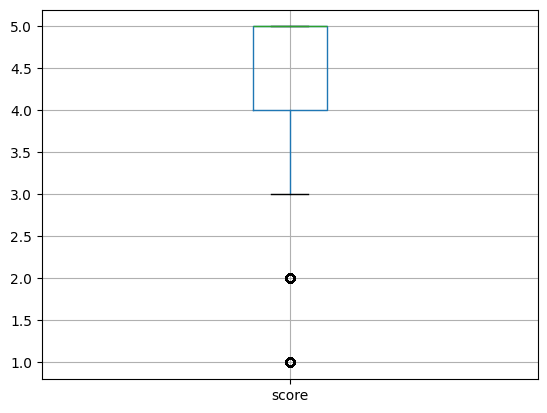

In [67]:
reviews.boxplot('score')

In [68]:
score_q1, score_q2, score_q3, score_IQR = get_quantiles_IQR(reviews,"score")

In [69]:
# Check number of outliers
reviews[reviews['score']< score_q1-1.5*score_IQR].shape[0]

81714

#### Helpfulness ratio distribution

<Axes: >

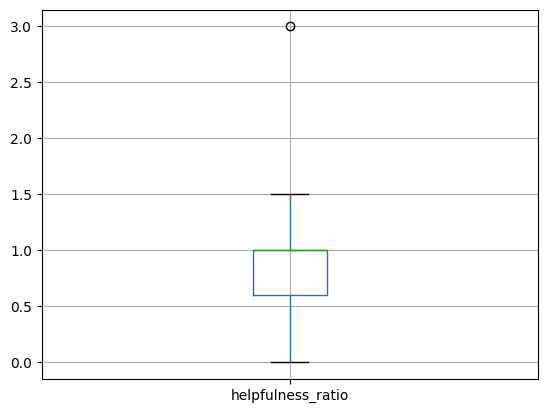

In [70]:
reviews.boxplot('helpfulness_ratio')

In [71]:
# Check number of reviews with helpfulness ratio higher than 1
print(f"# reviews with helpfulness ratio > 1 out of all = {reviews[reviews['helpfulness_ratio']>1].shape[0]} out of {reviews.shape[0]}")

# reviews with helpfulness ratio > 1 out of all = 2 out of 567130


There are only two reviews with a helpfulness ratio higher than one so we can remove them without much impact on the dataset.

In [72]:
mask = reviews['helpfulness_ratio']>1
reviews = reviews[~mask]

In [73]:
reviews.shape[0]

567128

<Axes: >

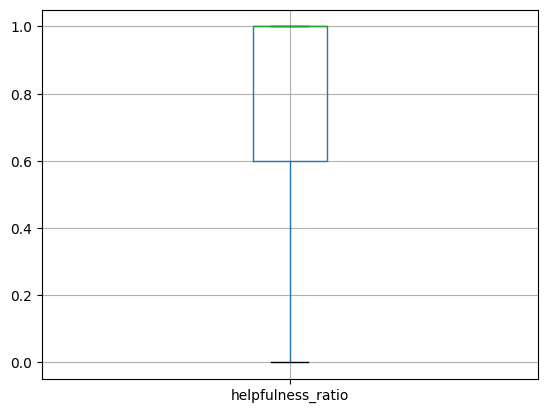

In [74]:
reviews.boxplot('helpfulness_ratio')

### Sentiment (label) distribution

<Axes: xlabel='sentiment'>

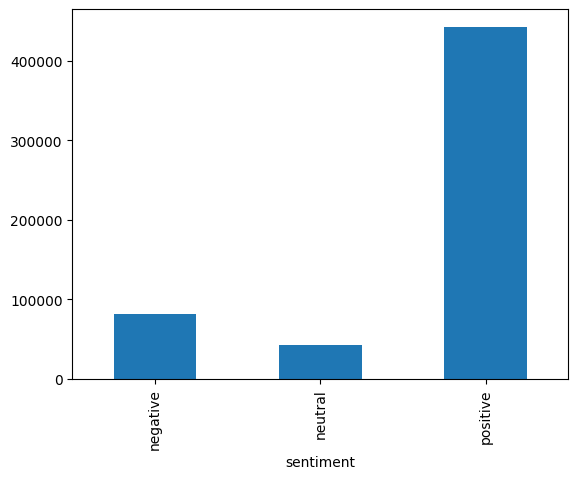

In [75]:
reviews.groupby(['sentiment']).size().plot.bar()

In [76]:
# Most of the reviews are positive (score >3) so a reference for accuracy is the value that considering all reviews as positive would give
print(f"Reference accuracy for dumb model = {reviews[reviews['sentiment']=='positive'].shape[0]/reviews.shape[0]*100:.2f} %")

Reference accuracy for dumb model = 78.09 %


#### Evolution of number of reviews per year

<Axes: xlabel='year'>

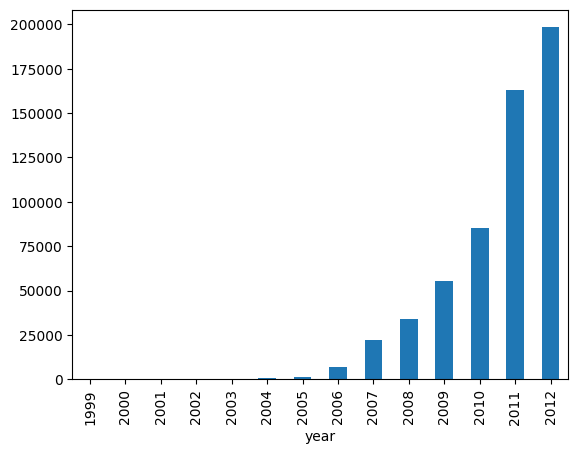

In [77]:
reviews.groupby(['year']).size().plot.bar()

In [78]:
reviews.shape[0]

567128

#### Cumulative number of reviews

In [79]:
yearly_reviews = reviews.groupby('year').size().to_frame()

yearly_reviews.rename(columns={0: 'num_reviews'}, inplace=True)


In [80]:
yearly_reviews['cum_reviews'] = yearly_reviews['num_reviews'].cumsum()

<Axes: xlabel='year'>

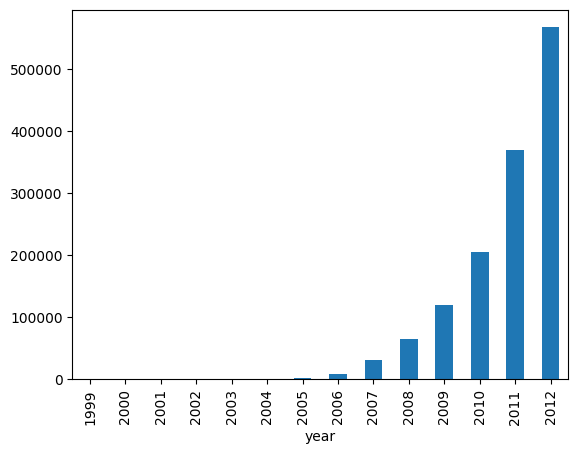

In [81]:
yearly_reviews['cum_reviews'].plot.bar()

#### Cumulative number of reviewers

In [82]:
yearly_reviewers = reviews[['user_id','year']].copy()

yearly_reviewers = yearly_reviewers.drop_duplicates(subset='user_id',keep='first')

In [83]:
yearly_reviewers = yearly_reviewers.groupby('year')['user_id'].nunique().to_frame()

yearly_reviewers.rename(columns={'user_id': 'num_users'}, inplace=True)


In [84]:
yearly_reviewers['cum_reviewers'] = yearly_reviewers['num_users'].cumsum()

In [85]:
yearly_reviewers['num_users']

year
1999        4
2000       14
2001        5
2002       32
2003       70
2004      319
2005      761
2006     3168
2007    10734
2008    14573
2009    23625
2010    38614
2011    72697
2012    91435
Name: num_users, dtype: int64

<Axes: xlabel='year'>

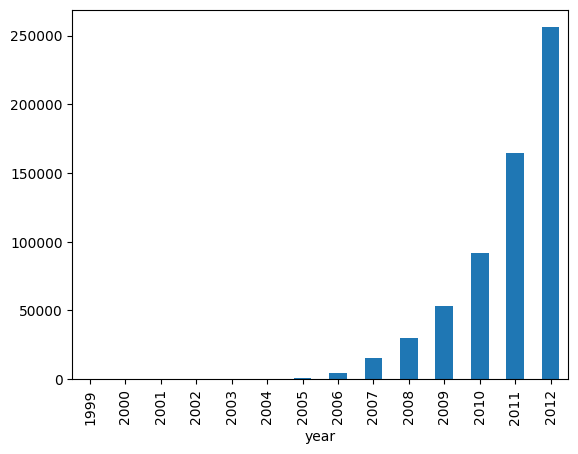

In [86]:
yearly_reviewers['cum_reviewers'].plot.bar()

#### Number of distinct products and users

In [87]:
user_ids = list(reviews['user_id'].unique())

print(f"# of distinct users = {len(user_ids)}")

# of distinct users = 256051


In [88]:
product_ids = list(reviews['product_id'].unique())

print(f"# of distinct products = {len(product_ids)}")

# of distinct products = 74258


#### Distribution of number of reviewers per product

In [89]:
reviews.groupby(['product_id'])['user_id'].count()

product_id
0006641040     37
141278509X      1
2734888454      2
2841233731      1
7310172001    170
             ... 
B009UOFTUI      1
B009UOFU20      1
B009UUS05I      1
B009WSNWC4      1
B009WVB40S      1
Name: user_id, Length: 74258, dtype: int64

In [90]:
reviews_per_product = reviews.groupby(['product_id'])['user_id'].count().to_numpy()

In [91]:
import seaborn as sns

<Axes: ylabel='Count'>

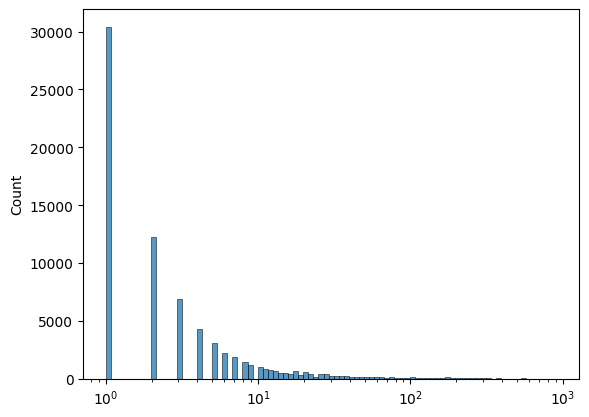

In [92]:
sns.histplot(reviews_per_product, log_scale=True)

In [93]:
(reviews_per_product ==1 ).sum() / reviews_per_product.shape[0]

0.4096124323305233

40% of products have only one reviewer.

#### Distribution of number of words in review text

<Axes: xlabel='word_count', ylabel='Count'>

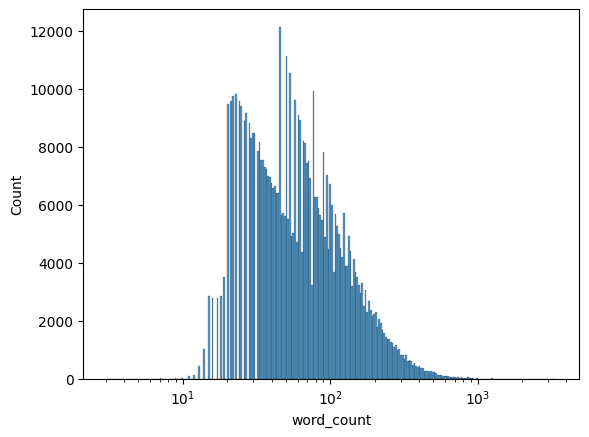

In [94]:
sns.histplot(reviews['word_count'], log_scale=True)

#### Q: How is the distribution of the number of words in the case of duplicated reviews? Are the duplicated reviews mostly short ones?

<Axes: xlabel='word_count', ylabel='Count'>

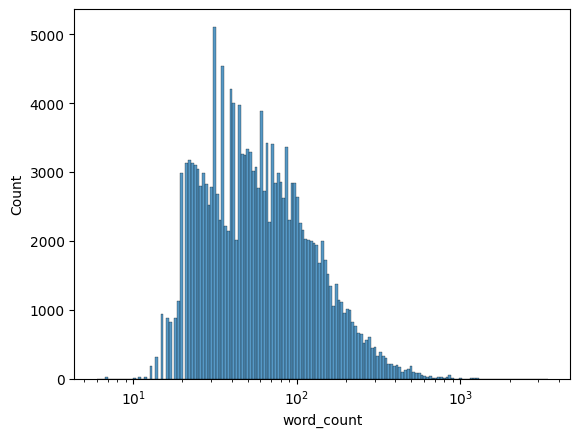

In [95]:
sns.histplot(reviews[reviews['duplicated']==True].word_count, log_scale=True)

<Axes: xlabel='word_count', ylabel='Count'>

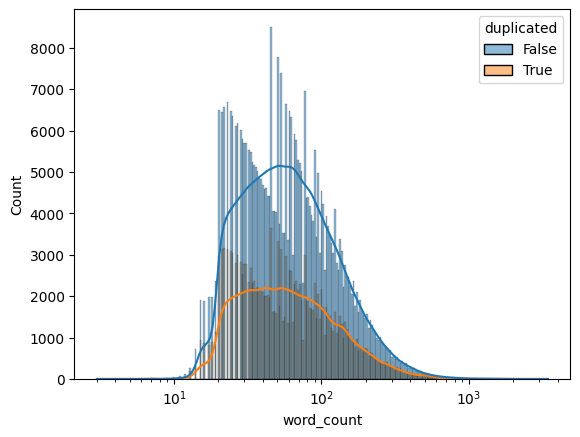

In [96]:
sns.histplot(reviews, x="word_count", hue="duplicated", kde=True, log_scale=True)

The fact that the duplicated reviews are spread along the number of words and are not restricted to just short reviews might indicate that they are not just the product of coincidence (people writing the same short sentence e.g.: "this is nice!"). However, the question still remains as to whether these are due to errors in the dataset or the reviewers not bothering to write original text and just using previous reviews for their own. One idea to deal with these reviews would be to assign them an average score if these are not too dispersed in time and score value.

# 4) Text preprocessing

### First cleansing of the text

In [97]:
#%pip install nltk

#nltk.download('stopwords')

In [98]:
import nltk
import string
import re

In [99]:
# This is just a first preprocessing function with steps that should be model independent
# (some models use specific tokenizers)

def preprocess_text(text, lower_case=True, remove_extra_wspaces=True, remove_punctuation=True,
                    remove_stop_words=True, remove_urls=True, remove_html=True):
    
    clean_text = text

    # Remove extra white spaces
    if remove_extra_wspaces:
        words = text.split()
        clean_text = " ".join(words)

    # Remove URLs
    if remove_urls:
        url_regex_pattern = r"(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?"
        clean_text = re.sub(url_regex_pattern, "", clean_text)
        
    # Remove HTML
    if remove_html:
        html_pattern = r"<[^>]+>"
        clean_text = re.sub(html_pattern, "", clean_text)
        
    tokens = nltk.word_tokenize(clean_text)

    stopwords = nltk.corpus.stopwords.words("english")

    # Lowercase tokens
    if lower_case:
        tokens = [token.lower() for token in tokens]

    # Remove stop words
    if remove_stop_words:
        tokens = [token for token in tokens if token not in stopwords]

    # Remove punctuation
    if remove_punctuation:
        tokens = [token for token in tokens if token not in string.punctuation]

    return " ".join(tokens)


Note: the cleansing process step below takes about 8 min. 

In [100]:
reviews['preprocessed_text'] = reviews.apply(lambda row: preprocess_text(row['text']), axis=1)

In [101]:
# Since the dataset is quite big and the text preprocessing takes time, save preprocessed data into new csv file
reviews.to_csv('../data/processed_reviews.csv')

### Lemmatization

In [102]:
from nltk.stem import WordNetLemmatizer

In [103]:
# Instantiate lemmatization
lemmatizer = WordNetLemmatizer()

In [104]:
def lemmatize_text(text, lemmatizer):

    processed_words = [lemmatizer.lemmatize(word) for word in text.split()]

    return " ".join(processed_words)

In [105]:
reviews['lemmatized_text'] = reviews.apply(lambda row: lemmatize_text(row['preprocessed_text'],lemmatizer), axis=1)

In [106]:
# Since the dataset is quite big and the text preprocessing takes time, save preprocessed data into new csv file
reviews.to_csv('../data/processed_reviews.csv')